<a href="https://colab.research.google.com/github/wendydonzse/709-Big-Data-Analysis/blob/main/Final_HotelBookingSpark_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
cd/content/gdrive/MyDrive/ColabNotebooks/709

/content/gdrive/MyDrive/ColabNotebooks/709


In [7]:
ls

 709HotelBookingPySpark.ipynb             monthly_booking_trends_output.csv/
 709HotelBookingSpark_ML.ipynb            monthly_booking_trends_spark.png
 cleaned_hotel_booking.csv                MPI_Dataset.csv
'Copy of 709HotelBookingSpark_ML.ipynb'   mpi_ds.csv
 hotel_booking.csv                        my_mpi_ds.csv
 HotelBooking.ipynb                       PySpark-3.ipynb
 MapReduceRDD.ipynb                       retail.csv
 MapReduceviaspark.ipynb                  transformed_hotel_booking.parquet/


In [8]:
!pip install pyspark

Monthly Booking Trends:
+------------------+------------+
|arrival_date_month|num_bookings|
+------------------+------------+
|            August|        8638|
|              July|        7919|
|               May|        7114|
|           October|        6914|
|             March|        6645|
|             April|        6565|
|              June|        6404|
|         September|        6392|
|          February|        5372|
|          November|        4672|
|          December|        4409|
|           January|        4122|
+------------------+------------+

Average ADR per Hotel:
+------------+------------------+
|       hotel|       average_adr|
+------------+------------------+
|  City Hotel|105.74594834299457|
|Resort Hotel| 90.78897055774631|
+------------+------------------+



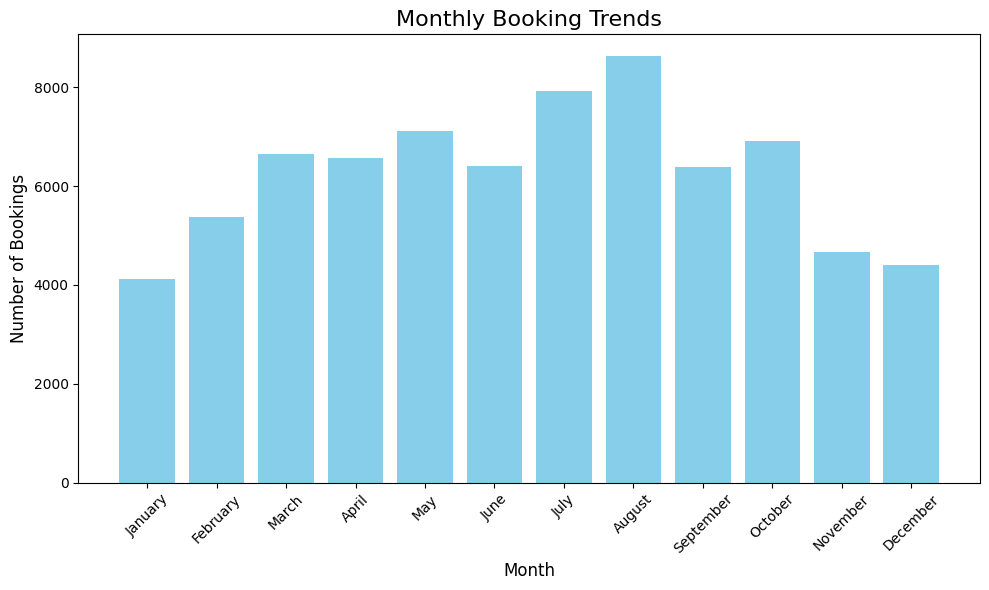

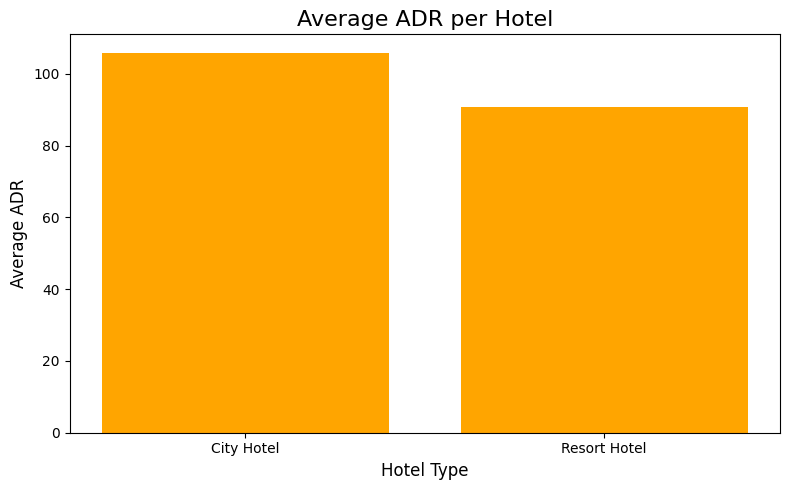

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg

import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Hotel Booking Analysis") \
    .getOrCreate()

# Load the CSV file into a DataFrame
file_path = "cleaned_hotel_booking.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Filter out canceled bookings
filtered_df = df.filter(col("is_canceled") == 0)

# Monthly Booking Trends
# Group by month and count the number of bookings
monthly_bookings = filtered_df.groupBy("arrival_date_month") \
    .agg(count("*").alias("num_bookings"))

# Sort by number of bookings to find highest and lowest months
sorted_monthly_bookings = monthly_bookings.orderBy(col("num_bookings").desc())

# Average ADR per Hotel
# Group by hotel and calculate the average ADR
average_adr = filtered_df.groupBy("hotel") \
    .agg(avg("adr").alias("average_adr"))

# Show results
print("Monthly Booking Trends:")
sorted_monthly_bookings.show()

print("Average ADR per Hotel:")
average_adr.show()


# Convert Spark DataFrames to Pandas for plotting before stopping the Spark Session
monthly_bookings_pd = sorted_monthly_bookings.toPandas()
average_adr_pd = average_adr.toPandas()

# Stop the Spark session
spark.stop()

# Sort months in calendar order for better visualization
# Define the correct order of months
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
monthly_bookings_pd["arrival_date_month"] = pd.Categorical(
    monthly_bookings_pd["arrival_date_month"], categories=month_order, ordered=True
)
monthly_bookings_pd = monthly_bookings_pd.sort_values("arrival_date_month")

# Plot Monthly Booking Trends
plt.figure(figsize=(10, 6))
plt.bar(monthly_bookings_pd["arrival_date_month"], monthly_bookings_pd["num_bookings"], color="skyblue")
plt.title("Monthly Booking Trends", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Bookings", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Average ADR per Hotel
plt.figure(figsize=(8, 5))
plt.bar(average_adr_pd["hotel"], average_adr_pd["average_adr"], color="orange")
plt.title("Average ADR per Hotel", fontsize=16)
plt.xlabel("Hotel Type", fontsize=12)
plt.ylabel("Average ADR", fontsize=12)
plt.tight_layout()
plt.show()

In [16]:
# Task 3: Implement Machine Learning Algorithms on Big Data for Predictions and Classification on Time Series Data
# Perform any data preparation tasks in terms of transforming the data into a usable format and loading it for analysis. The cleanned_hotel_booking already been cleaned
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Initialize Spark session
spark = SparkSession.builder.appName("HotelBookingPrediction").getOrCreate()

# Load the CSV file into a DataFrame
file_path = "/content/gdrive/MyDrive/ColabNotebooks/709/cleaned_hotel_booking.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)


In [17]:
# Handle missing values (e.g., fill nulls with 0 or mode for categorical columns)
df = df.fillna({"children": 0, "babies": 0, "agent": 0, "company": 0})


In [18]:
# Feature engineering
df = df.withColumn("total_nights", col("stays_in_weekend_nights") + col("stays_in_week_nights"))
df = df.withColumn("family_size", col("adults") + col("children") + col("babies"))


In [19]:
# Encode categorical variables
categorical_cols = ["hotel", "meal", "country", "market_segment", "distribution_channel", "reserved_room_type"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec") for col in categorical_cols]

# Assemble features
feature_cols = ["lead_time", "total_nights", "family_size", "adr"] + [col + "_vec" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [20]:
# Pipeline for data preparation
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])
prepared_df = pipeline.fit(df).transform(df)

In [21]:
# Split data into training and testing sets
train_df, test_df = prepared_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Classfication Task perform 2 ML models: Logistic Regression and Random Forest for classification.

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[13042.  1980.]
 [ 3811.  5107.]]
Accuracy: 0.7581
Precision: 0.7540
Recall: 0.7581
F1-Score: 0.7512
AUC: 0.8166


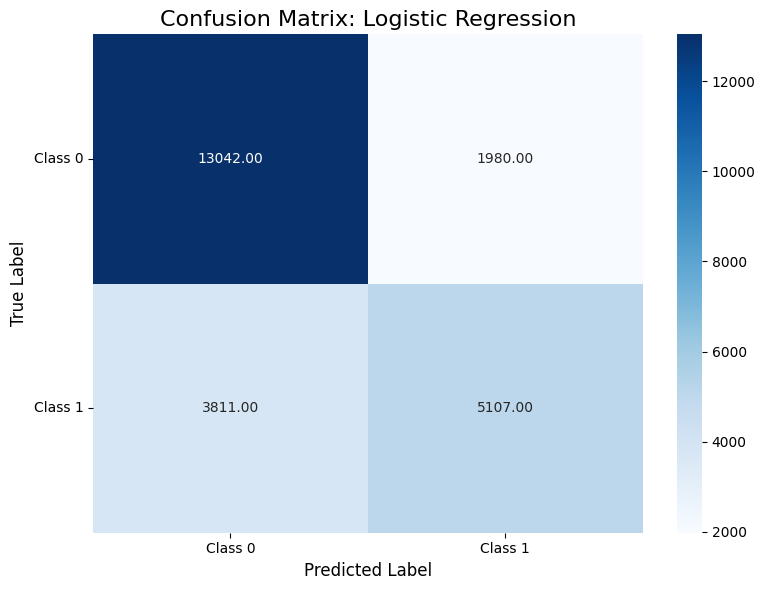

In [ ]:
# Classfication Task perform 2 ML models: Logistic Regression and Random Forest for classification.
# %%
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics  # Import MulticlassMetrics for confusion matrix
from pyspark.ml.feature import StringIndexer # Import StringIndexer for creating "label" column

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a "label" column using StringIndexer before fitting the model
# This will ensure that the "label" column is available for evaluation
labelIndexer = StringIndexer(inputCol="is_canceled", outputCol="label")
train_df = labelIndexer.fit(train_df).transform(train_df)  # Apply to training data
test_df = labelIndexer.fit(test_df).transform(test_df)    # Apply to testing data

# Logistic Regression
lr = LogisticRegression(featuresCol="scaled_features", labelCol="label") # Use "label" column here
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

# Evaluate metrics
# Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)

# Precision, Recall, F1-Score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

lr_precision = precision_evaluator.evaluate(lr_predictions)
lr_recall = recall_evaluator.evaluate(lr_predictions)
lr_f1_score = f1_evaluator.evaluate(lr_predictions)

# AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
lr_auc = binary_evaluator.evaluate(lr_predictions)

# Confusion Matrix
prediction_and_labels = lr_predictions.select("prediction", "label").rdd.map(lambda x: (x[0], x[1]))
metrics = MulticlassMetrics(prediction_and_labels)
lr_confusion_matrix = metrics.confusionMatrix().toArray() # use confusionMatrix() for MulticlassMetrics

# Print metrics
print("Confusion Matrix:")
print(lr_confusion_matrix)
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1_score:.4f}")
print(f"AUC: {lr_auc:.4f}")

# Visualize Confusion Matrix
# Create a heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(lr_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)  # Changed fmt to ".2f"
# Add labels, title, and axis ticks

plt.title("Confusion Matrix: Logistic Regression", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(np.arange(lr_confusion_matrix.shape[1]) + 0.5, labels=[f"Class {i}" for i in range(lr_confusion_matrix.shape[1])])
plt.yticks(np.arange(lr_confusion_matrix.shape[0]) + 0.5, labels=[f"Class {i}" for i in range(lr_confusion_matrix.shape[0])], rotation=0)
# Show the plot

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[14718.   304.]
 [ 6501.  2417.]]
Accuracy: 0.7157
Precision: 0.7661
Recall: 0.7157
F1-Score: 0.6644
AUC: 0.8104


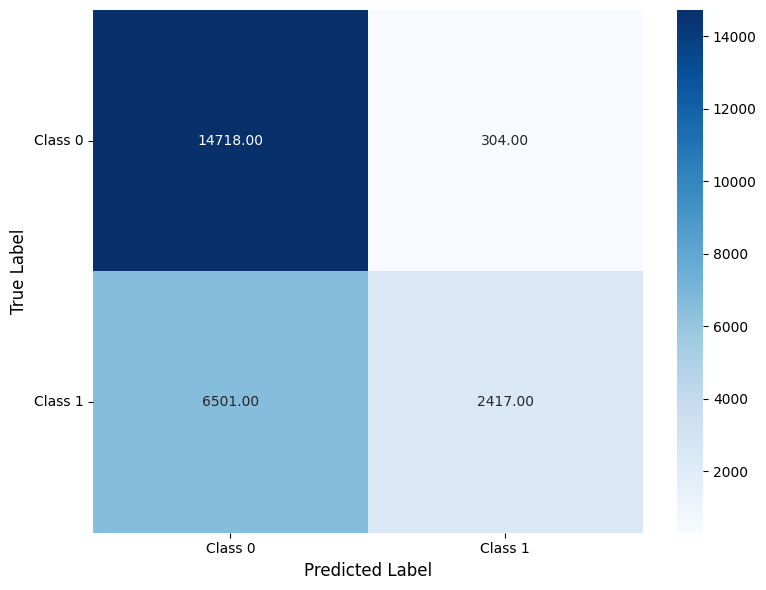

In [ ]:

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="is_canceled", numTrees=50)
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

# Evaluate metrics
# Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)

# Precision, Recall, F1-Score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

rf_precision = precision_evaluator.evaluate(rf_predictions)
rf_recall = recall_evaluator.evaluate(rf_predictions)
rf_f1_score = f1_evaluator.evaluate(rf_predictions)

# AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
rf_auc = binary_evaluator.evaluate(rf_predictions)

# Confusion Matrix
prediction_and_labels = rf_predictions.select("prediction", "label").rdd.map(lambda x: (x[0], x[1]))
metrics = MulticlassMetrics(prediction_and_labels)
rf_confusion_matrix = metrics.confusionMatrix().toArray()  # Changed to confusionMatrix()

# Print metrics
print("Confusion Matrix:")
print(rf_confusion_matrix)
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1_score:.4f}")
print(f"AUC: {rf_auc:.4f}")

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True) # Changed fmt to ".2f"
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(np.arange(rf_confusion_matrix.shape[1]) + 0.5, labels=[f"Class {i}" for i in range(rf_confusion_matrix.shape[1])])
plt.yticks(np.arange(rf_confusion_matrix.shape[0]) + 0.5, labels=[f"Class {i}" for i in range(rf_confusion_matrix.shape[0])], rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Decision Tree ML model for cleaned_hotel_booking.csv dataset
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[13352.  1670.]
 [ 2786.  6132.]]
Accuracy: 0.8139
Precision: 0.8119
Recall: 0.8139
F1-Score: 0.8110
AUC: 0.8217


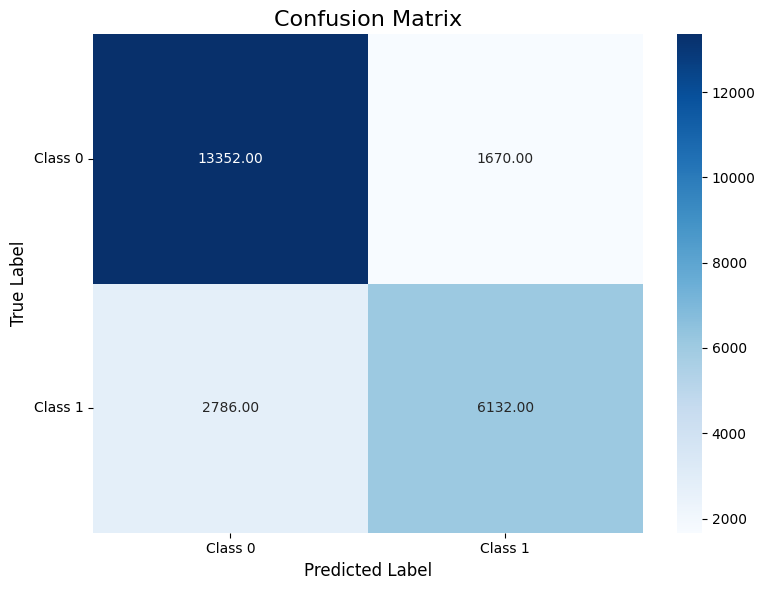

In [ ]:
# Assemble features
feature_cols = ["lead_time", "total_nights", "family_size", "adr", "is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled", "booking_changes", "days_in_waiting_list", "required_car_parking_spaces",
                "total_of_special_requests"] + [col + "_index" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Target variable: is_canceled
label_indexer = StringIndexer(inputCol="is_canceled", outputCol="label")

# Apply transformations
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + [assembler, label_indexer])
prepared_df = pipeline.fit(df).transform(df)

# Split data into training and testing sets
train_df, test_df = prepared_df.randomSplit([0.8, 0.2], seed=42)

# Train Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=5, maxBins=178) # Increased maxBins to accommodate the categorical feature with 178 values
dt_model = dt.fit(train_df)

# Make predictions
dt_predictions = dt_model.transform(test_df)

# Evaluate the model
# Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)

# Precision, Recall, F1-Score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

dt_precision = precision_evaluator.evaluate(dt_predictions)
dt_recall = recall_evaluator.evaluate(dt_predictions)
dt_f1_score = f1_evaluator.evaluate(dt_predictions)

# AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
dt_auc = binary_evaluator.evaluate(dt_predictions)

# Confusion Matrix
# Convert predictions to RDD for confusion matrix calculation
prediction_and_labels = dt_predictions.select("prediction", "label").rdd.map(lambda x: (x[0], x[1]))
metrics = MulticlassMetrics(prediction_and_labels)
dt_confusion_matrix = metrics.confusionMatrix().toArray()

# Print results
print("Confusion Matrix:")
print(dt_confusion_matrix)
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall: {dt_recall:.4f}")
print(f"F1-Score: {dt_f1_score:.4f}")
print(f"AUC: {dt_auc:.4f}")

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(dt_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)

# Add labels, title, and axis ticks
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(np.arange(dt_confusion_matrix.shape[1]) + 0.5, labels=[f"Class {i}" for i in range(dt_confusion_matrix.shape[1])])
plt.yticks(np.arange(dt_confusion_matrix.shape[0]) + 0.5, labels=[f"Class {i}" for i in range(dt_confusion_matrix.shape[0])], rotation=0)

# Show the plot
plt.tight_layout()
plt.show()




In [22]:
# Linear Regression (LR) and # Random Forest Regressor and # Gradient-Boosted Trees Regressor

from pyspark.ml.regression import RandomForestRegressor, LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


# Load the CSV file into a DataFrame
file_path = "/content/gdrive/MyDrive/ColabNotebooks/709/cleaned_hotel_booking.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Feature selection and preprocessing
# We'll predict 'adr' (average daily rate) as the target variable
# Drop non-numeric or irrelevant columns for simplicity
columns_to_drop = ["hotel", "arrival_date_month", "country", "reservation_status", "reservation_status_date", "meal", "market_segment", "distribution_channel", "customer_type", "reserved_room_type", "assigned_room_type", "deposit_type"]
data = df.drop(*columns_to_drop)

# Fill missing values
data = data.fillna(0)

# Assemble features
feature_columns = [col for col in data.columns if col != "adr"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data).select("features", "adr")

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="adr", seed=42)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="adr")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Gradient-Boosted Trees Regressor
gbt = GBTRegressor(featuresCol="features", labelCol="adr", maxIter=50, maxBins=178) # Set maxBins to at least 178
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

# Evaluation
rf_evaluator = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="rmse")
rf_rmse = rf_evaluator.evaluate(rf_predictions)
rf_r2 = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="r2").evaluate(rf_predictions)

lr_evaluator = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="rmse")
lr_rmse = lr_evaluator.evaluate(lr_predictions)
lr_r2 = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="r2").evaluate(lr_predictions)

gbt_evaluator = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="rmse")
gbt_rmse = gbt_evaluator.evaluate(gbt_predictions)
gbt_r2 = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="r2").evaluate(gbt_predictions)


# Return results
rf_results = {"Random Forest RMSE": rf_rmse, "Random Forest R2": rf_r2}
lr_results = {"Linear Regression  RMSE": lr_rmse, "Linear Regression  R2": lr_r2}
gbt_results = {"Gradient-Boosted Trees RMSE": gbt_rmse, "Gradient-Boosted Trees R2": gbt_r2}

rf_results, lr_results, gbt_results



({'Random Forest RMSE': 37.48813186411743,
  'Random Forest R2': 0.3946345777906862},
 {'Linear Regression  RMSE': 40.934628440064785,
  'Linear Regression  R2': 0.2782085745477393},
 {'Gradient-Boosted Trees RMSE': 2.191285608095366,
  'Gradient-Boosted Trees R2': 0.9979268145868004})

In [26]:
# Hyperparameter tuning for each model

spark = SparkSession.builder.appName("HotelBookingPrediction").getOrCreate()

from pyspark.ml.evaluation import RegressionEvaluator # Import RegressionEvaluator


ConnectionRefusedError: [Errno 111] Connection refused

In [24]:
# Random Forest
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_param_grid, evaluator=RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="rmse"), numFolds=3) # Use RegressionEvaluator here
rf_model = rf_cv.fit(train_data)
rf_best_model = rf_model.bestModel
rf_rmse = evaluator.evaluate(rf_best_model.transform(test_data))
rf_r2 = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="r2").evaluate(rf_best_model.transform(test_data))


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.us

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
# Linear Regression
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_param_grid, evaluator=evaluator, numFolds=3)
lr_model = lr_cv.fit(train_data)
lr_best_model = lr_model.bestModel
lr_rmse = evaluator.evaluate(lr_best_model.transform(test_data))
lr_r2 = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="r2").evaluate(lr_best_model.transform(test_data))


In [ ]:
# Gradient-Boosted Trees
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 20]) \
    .addGrid(gbt.maxIter, [10, 50, 100]) \
    .build()
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_param_grid, evaluator=evaluator, numFolds=3)
gbt_model = gbt_cv.fit(train_data)
gbt_best_model = gbt_model.bestModel
gbt_rmse = evaluator.evaluate(gbt_best_model.transform(test_data))
gbt_r2 = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="r2").evaluate(gbt_best_model.transform(test_data))


In [ ]:
# Output the results
results = {
    "Random Forest": {"RMSE": rf_rmse, "R2": rf_r2},
    "Linear Regression": {"RMSE": lr_rmse, "R2": lr_r2},
    "Gradient-Boosted Trees": {"RMSE": gbt_rmse, "R2": gbt_r2}
}

results

In [25]:
# Hyperparameter tuning for each model
from pyspark.ml.evaluation import RegressionEvaluator # Import RegressionEvaluator


# Random Forest
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

rf_evaluator = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="rmse")
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_param_grid, evaluator=RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="rmse"), numFolds=3) # Use RegressionEvaluator here
rf_model = rf_cv.fit(train_data)
rf_best_model = rf_model.bestModel
rf_rmse = evaluator.evaluate(rf_best_model.transform(test_data))
rf_r2 = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="r2").evaluate(rf_best_model.transform(test_data))

# Linear Regression
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_param_grid, evaluator=evaluator, numFolds=3)
lr_model = lr_cv.fit(train_data)
lr_best_model = lr_model.bestModel
lr_rmse = evaluator.evaluate(lr_best_model.transform(test_data))
lr_r2 = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="r2").evaluate(lr_best_model.transform(test_data))

# Gradient-Boosted Trees
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 20]) \
    .addGrid(gbt.maxIter, [10, 50, 100]) \
    .build()
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_param_grid, evaluator=evaluator, numFolds=3)
gbt_model = gbt_cv.fit(train_data)
gbt_best_model = gbt_model.bestModel
gbt_rmse = evaluator.evaluate(gbt_best_model.transform(test_data))
gbt_r2 = RegressionEvaluator(labelCol="adr", predictionCol="prediction", metricName="r2").evaluate(gbt_best_model.transform(test_data))

# Output the results
results = {
    "Random Forest": {"RMSE": rf_rmse, "R2": rf_r2},
    "Linear Regression": {"RMSE": lr_rmse, "R2": lr_r2},
    "Gradient-Boosted Trees": {"RMSE": gbt_rmse, "R2": gbt_r2}
}

results
spark.stop()
# Restart the Spark session if it has been stopped
try:
    spark
except NameError:
    spark = SparkSession.builder.appName("HotelBookingPrediction").getOrCreate()

# Hyperparameter tuning for each model
from pyspark.ml.evaluation import RegressionEvaluator # Import RegressionEvaluator



ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Example: Hyperparameter tuning for Random Forest
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

cv_model = crossval.fit(train_df)
best_model = cv_model.bestModel
print(f"Best Random Forest Model: {best_model}")

Best Random Forest Model: RandomForestClassificationModel: uid=RandomForestClassifier_366a5bf515f4, numTrees=10, numClasses=2, numFeatures=206


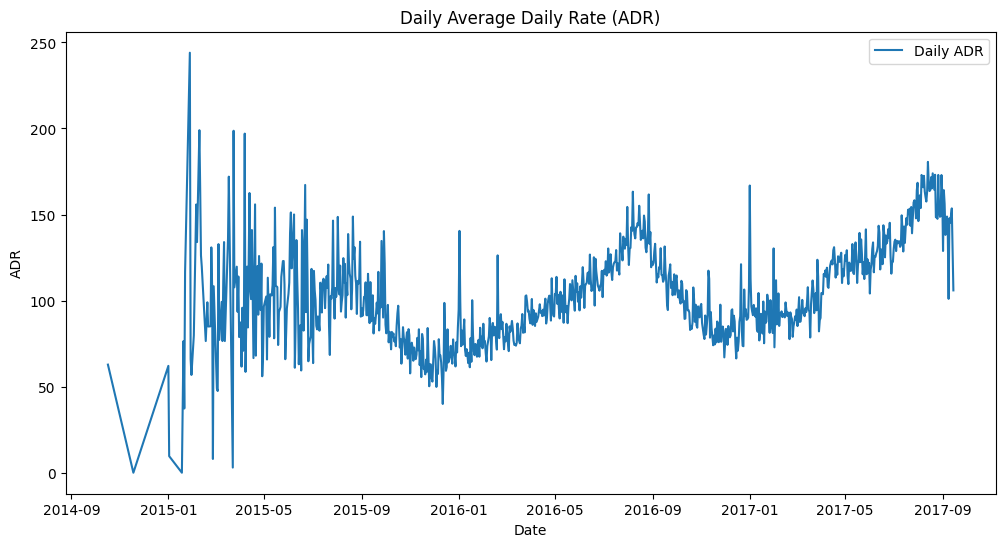

,reservation_status_date,mean_adr
0,2014-10-17,62.800000
1,2014-11-18,0.000000
2,2015-01-01,62.062779
3,2015-01-02,9.633750
4,2015-01-18,0.000000


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, mean
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("TimeSeriesADR").getOrCreate()

# Load the dataset into a Spark DataFrame
# Use the absolute path of the file

# Load the CSV file into a DataFrame
file_path = "/content/gdrive/MyDrive/ColabNotebooks/709/cleaned_hotel_booking.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert 'reservation_status_date' to date type
data = data.withColumn('reservation_status_date', to_date(col('reservation_status_date')))

# Group by day and calculate the mean ADR
daily_adr = data.groupBy('reservation_status_date').agg(mean('adr').alias('mean_adr')).orderBy('reservation_status_date')

# Convert to Pandas DataFrame for plotting
daily_adr_pd = daily_adr.toPandas()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(daily_adr_pd['reservation_status_date'], daily_adr_pd['mean_adr'], label='Daily ADR')
plt.title('Daily Average Daily Rate (ADR)')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.legend()
plt.show()

daily_adr_pd.head()

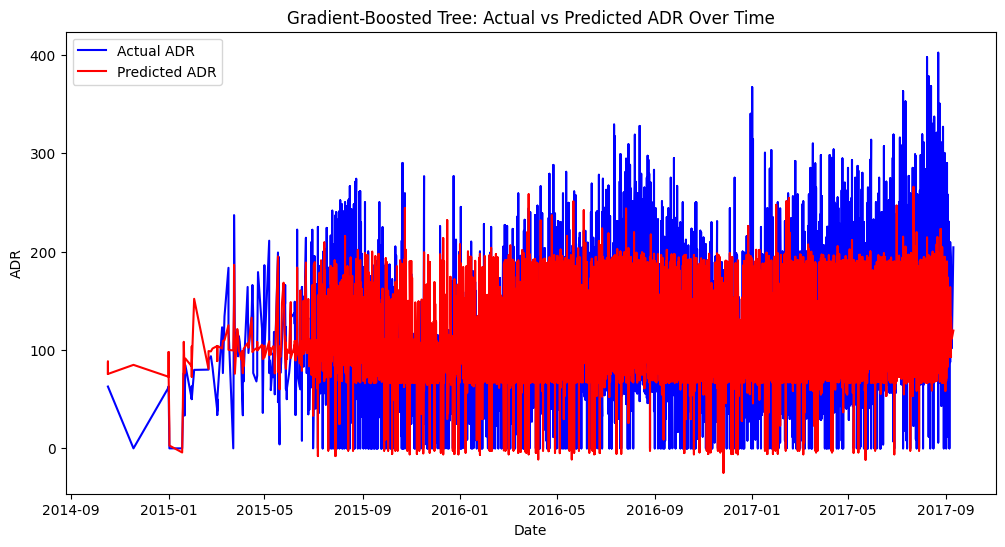

In [19]:
# Perform Gradient Boosted ML on Time series
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("GBT_Prediction").getOrCreate()

# Load the CSV file into a DataFrame
file_path = "/content/gdrive/MyDrive/ColabNotebooks/709/cleaned_hotel_booking.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)


# Convert 'reservation_status_date' to date type
data = data.withColumn('reservation_status_date', to_date(col('reservation_status_date')))

# Select relevant features and target variable for prediction
# Features: 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'total_nights', 'family_size'
# Target: 'adr'
selected_columns = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'total_nights', 'family_size', 'adr', 'reservation_status_date']
data = data.select(*selected_columns).dropna()

# Assemble features into a single vector
feature_columns = selected_columns[:-2]  # All except 'adr' and 'reservation_status_date'
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = assembler.transform(data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the Gradient-Boosted Tree Regressor
gbt = GBTRegressor(featuresCol='features', labelCol='adr', maxIter=50)
model = gbt.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Convert predictions to Pandas DataFrame for plotting
predictions_pd = predictions.select("reservation_status_date", "adr", "prediction").toPandas()

# Sort by date for better visualization
predictions_pd = predictions_pd.sort_values(by="reservation_status_date")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['reservation_status_date'], predictions_pd['adr'], color='blue', label='Actual ADR')
plt.plot(predictions_pd['reservation_status_date'], predictions_pd['prediction'], color='red', label='Predicted ADR')
plt.xlabel('Date')
plt.ylabel('ADR')
plt.title('Gradient-Boosted Tree: Actual vs Predicted ADR Over Time')
plt.legend()
plt.show()